# Siamese Network for Tree Crown Species Classifcation

This notebook trains a siamese network with ideas derived from [face recognition](https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4) in order to classify tree crowns to different species of interest. This work is motivated by the need for a few shot learning model to detect tree species due to limited availability of data-sets.

Difference from previous experiment: Reduced number of neurons in all layers

In [1]:
# Import libraries
import keras
import tensorflow as tf
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
from classification_models.keras import Classifiers

2023-09-08 15:08:38.906835: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 15:08:39.070079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model Implementation

In [2]:
# Set Keras backend for image data format

keras.backend.set_image_data_format('channels_first')

### Create the base model that extracts features from the input images
Both input images that are to be compared are run through the same network to provide embeddings whose similarity will be compared

In [22]:
def create_model():
    inputs = keras.Input((3, 100, 100))
    x = keras.layers.Conv2D(32, (5, 5), padding="same", activation="relu")(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Conv2D(64, (5, 5), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.3)(x)

    pooledOutput = keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = keras.layers.Dense(128)(pooledOutput)
    outputs = keras.layers.Dense(32)(pooledOutput)

    model = keras.Model(inputs, outputs)
    return model

### Extract features from the base network

In [23]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

In [24]:
def siamese_model():
    feature_extractor_model = create_model()
    imgA = keras.Input(shape=(3, 100, 100))
    imgB = keras.Input(shape=(3, 100, 100))
    featA = feature_extractor_model(imgA)
    featB = feature_extractor_model(imgB)
    distance = keras.layers.Lambda(euclidean_distance)([featA, featB])
    #  outputs = keras.layers.Dense(1)(distance)
    outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
    model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
    return model

In [6]:
# model = siamese_model()
# model.summary()

In [25]:
def compile_model(model, lr):
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    metrics = [keras.metrics.BinaryAccuracy(threshold=0.5)]
    model.compile(loss=loss, optimizer=opt, metrics=metrics)

# Data Preparation

Read the IDTreeS Dataset and cut-out individual tree crowns

In [8]:
import glob

from rioxarray.exceptions import NoDataInBounds
from sklearn.preprocessing import LabelEncoder 
import IDTreeS_dataset

# Data Loader from IDTreeS Dataset
rgb_paths = glob.glob('../train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('../train/ITC/train_*.shp')
classes_path = '../train/Field/train_data.csv'

In [9]:
# Convert generator dataset in to suitable input for keras
ds = IDTreeS_dataset.IDTreeSDataset(rgb_paths, bboxes_paths, classes_path, augment_data=False)

ids, Y, X = ds.get_cutouts()

nclasses = len(np.unique(Y)) #Number of classes in training data

Preprocess the dataset to remove classes with few examples and classes that look very similar to each other. 

Finally, classes 0, 4, and 8 have been selected to train the network.

In [10]:
def preprocess_data(X, Y):
    classes = [0, 4, 8]
    mask = np.isin(Y, classes)
    X_red = X[mask]
    Y_red = Y[mask]
    for i in range(len(classes)):
        mask = np.isin(Y_red, classes[i])
        Y_red[mask] = i
    return X_red, Y_red

X, Y = preprocess_data(X, Y)

Create positive and negative image pairs from the dataset:

In [11]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    label_wise_samples = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    samples = {key: len(value) for key, value in label_wise_indices.items()}
    for i in range(len(label_wise_indices)):
        label_wise_samples[i] = label_wise_indices[i][0:min(samples.values())] 

    pair_images = []
    pair_labels = []
    pair_index = []
    for index, image in enumerate(images_dataset):
        if index in np.ndarray.flatten(np.array(([*label_wise_samples.values()]))):
            pos_indices = label_wise_samples.get(labels_dataset[index])
            pos_index = np.random.choice(pos_indices)
            pos_image = images_dataset[pos_index]
            pair_images.append((image, pos_image))
            pair_labels.append(1)
            pair_index.append((index,pos_index))

            neg_indices = np.setdiff1d(np.ndarray.flatten(np.array(([*label_wise_samples.values()]))), pos_indices)
            neg_index = np.random.choice(neg_indices)
            neg_image = images_dataset[neg_index]
            pair_images.append((image, neg_image))
            pair_index.append((index,neg_index))
            pair_labels.append(0)
        else:
            continue
    return np.array(pair_images), np.array(pair_labels), np.array(pair_index)

In [12]:
images_pair, labels_pair, index_pair = generate_train_image_pairs(X, Y)
index_pair.shape

(558, 2)

# Explore and identify dissimilar classes 

(Classes 0, 4 and 7 appear visually different)

In [13]:
# unique_labels = np.unique(Y)
# label_wise_indices = dict()
# label_wise_samples = dict()
# for label in unique_labels:
#     label_wise_indices.setdefault(label,
#                                     [index for index, curr_label in enumerate(Y) if
#                                     label == curr_label])

In [14]:
# fig = plt.figure(figsize=(14, 14))

# for i in range(len(unique_labels)):
#     sub = fig.add_subplot(3, 3, i+1)
#     idx_idx = np.random.randint(len(label_wise_indices[i][:]))
#     idx = label_wise_indices[i][idx_idx]
#     sub.imshow(X[idx,:,:,:].transpose(1,2,0).astype('int'))
#     sub.set_ylabel(Y[idx], fontsize=16)
#     sub.set_xlabel(idx, fontsize=16)

In [15]:
# for i in range(len(label_wise_indices)):
#     print (len(label_wise_indices[i]))

In [16]:
# fig = plt.figure(figsize=(15, 20))
# j = 0
# for i in range(4):
#     # idx = np.random.randint(6624)
#     sub = fig.add_subplot(4, 2, j + 1)
#     j = j+1
#     idx = np.random.randint(images_pair.shape[0])
#     sub.imshow(images_pair[idx,0,:,:,:].transpose(1,2,0).astype('int'))
#     sub.set_ylabel(labels_pair[idx], fontsize=16)
#     sub.set_xlabel(idx, fontsize=16)
#     sub = fig.add_subplot(4, 2, j + 1)
#     j = j+1
#     sub.imshow(images_pair[idx,1,:,:,:].transpose(1,2,0).astype('int'))
#     sub.set_ylabel(labels_pair[idx], fontsize=16)
#     sub.set_xlabel(idx, fontsize=16)

# plt.show(block=True)

# Run the model training

In [26]:
model = siamese_model()
model.save_weights('weights_32_64_96_128_32.h5')

In [27]:
model.load_weights('weights_32_64_96_128_32.h5')
# model.load_weights('weights_logits.h5')
# model = siamese_model()
compile_model(model, 0.01)
print(k.eval(model.optimizer.lr))
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=5, restore_best_weights=True)

0.01


In [31]:
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:], validation_split=0.2, batch_size=64, epochs=30, callbacks=callbacks)

Epoch 1/30
7/7 [==============================] - 10s 1s/step - loss: 0.5349 - binary_accuracy: 0.7332 - val_loss: 0.6103 - val_binary_accuracy: 0.6339
Epoch 2/30
7/7 [==============================] - 8s 1s/step - loss: 0.5463 - binary_accuracy: 0.7377 - val_loss: 0.6154 - val_binary_accuracy: 0.6071
Epoch 3/30
7/7 [==============================] - 8s 1s/step - loss: 0.5617 - binary_accuracy: 0.7175 - val_loss: 0.5313 - val_binary_accuracy: 0.7589
Epoch 4/30
7/7 [==============================] - 7s 1s/step - loss: 0.5276 - binary_accuracy: 0.7377 - val_loss: 0.5047 - val_binary_accuracy: 0.8125
Epoch 5/30
7/7 [==============================] - 8s 1s/step - loss: 0.5336 - binary_accuracy: 0.7220 - val_loss: 0.5818 - val_binary_accuracy: 0.6696
Epoch 6/30
7/7 [==============================] - 8s 1s/step - loss: 0.5143 - binary_accuracy: 0.7399 - val_loss: 0.4650 - val_binary_accuracy: 0.8750
Epoch 7/30
7/7 [==============================] - 8s 1s/step - loss: 0.5083 - binary_accuracy

### Prediction and Result Analysis

In [32]:
labels_pred = model.predict([images_pair[:, 0], images_pair[:, 1]])

18/18 [==============================] - 4s 244ms/step


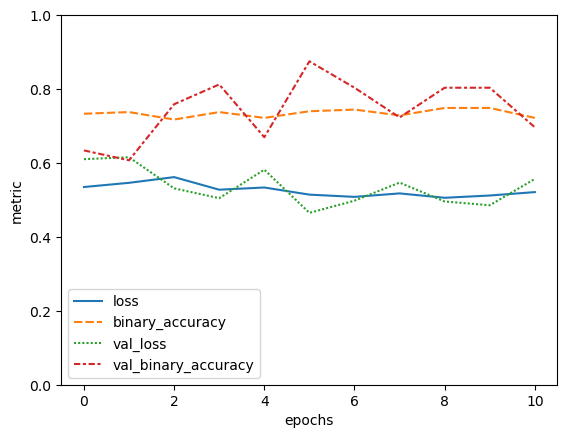

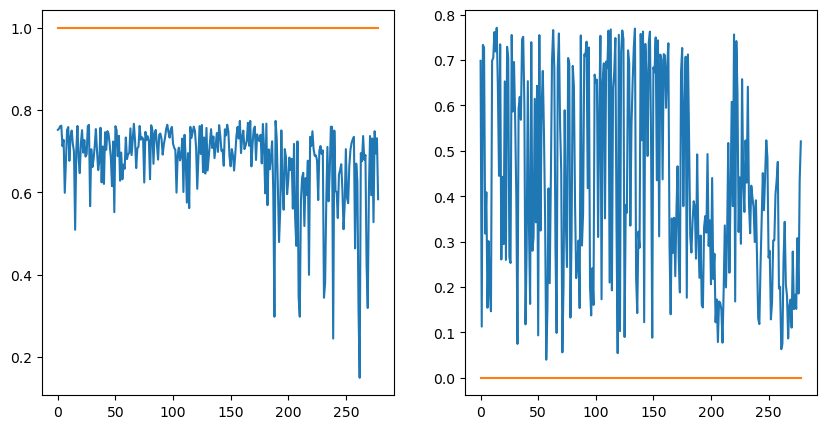

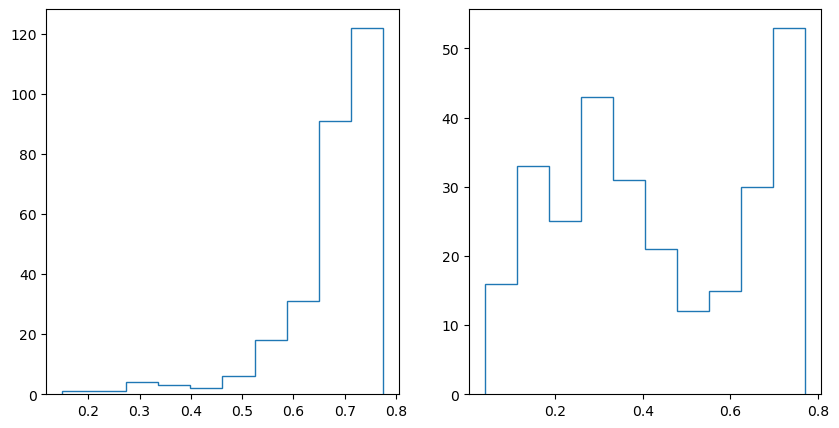

In [33]:
import seaborn as sns
import pandas as pd
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")
    plt.ylim(0, 1)

plot_history(history, ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'] )

fig = plt.figure(figsize=(10, 5))

sub = fig.add_subplot(1, 2, 1)
sub.plot(labels_pred[::2])
# sub.plot(np.round(labels_pred[::2]))
sub.plot(labels_pair[::2])

sub = fig.add_subplot(1, 2, 2)
sub.plot(labels_pred[1::2])
# sub.plot(np.round(labels_pred[1::2]))
sub.plot(labels_pair[1::2])

fig2 = plt.figure(figsize=(10, 5))

counts, bins = np.histogram(labels_pred[::2])
sub = fig2.add_subplot(1, 2, 1)
sub.stairs(counts, bins)
# sub.plot(np.round(labels_pred[::2]))
# sub.plot(labels_pair[::2])

sub = fig2.add_subplot(1, 2, 2)
counts, bins = np.histogram(labels_pred[1::2])
sub.stairs(counts, bins)
# sub.plot(np.round(labels_pred[1::2]))
# sub.plot(labels_pair[1::2])
